In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device(0)

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [5]:
spy_df = pd.read_csv("../data/spy_data.csv")

In [6]:
spy_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2003-07-22 00:00:00-04:00,67.246893,67.737498,66.722215,67.573959,49968300,0.0,0.0,0.0
1,2003-07-23 00:00:00-04:00,67.601233,67.764766,66.967535,67.621674,37275400,0.0,0.0,0.0
2,2003-07-24 00:00:00-04:00,68.132719,68.371207,67.028862,67.110626,40896200,0.0,0.0,0.0
3,2003-07-25 00:00:00-04:00,67.226474,68.337147,66.804007,68.296265,43241100,0.0,0.0,0.0
4,2003-07-28 00:00:00-04:00,68.391634,68.807285,67.914654,68.044121,34382800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5030,2023-07-17 00:00:00-04:00,449.130005,451.929993,449.079987,450.839996,52680200,0.0,0.0,0.0
5031,2023-07-18 00:00:00-04:00,450.500000,454.859985,450.049988,454.190002,80744400,0.0,0.0,0.0
5032,2023-07-19 00:00:00-04:00,455.010010,456.429993,454.109985,455.200012,65891700,0.0,0.0,0.0
5033,2023-07-20 00:00:00-04:00,454.170013,455.100006,451.440002,452.179993,70591600,0.0,0.0,0.0


In [7]:
 df = spy_df
timeseries = df[["Close"]].values.astype('float32')

In [8]:
timeseries

array([[ 67.57396],
       [ 67.62167],
       [ 67.11063],
       ...,
       [455.2    ],
       [452.18   ],
       [452.18   ]], dtype=float32)

In [9]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [10]:
maximum = train.max()
minimum = train.min()

In [11]:
maximum, minimum

(201.2862, 51.568043)

In [12]:
train

array([[ 67.57396],
       [ 67.62167],
       [ 67.11063],
       ...,
       [199.58888],
       [200.0776 ],
       [201.2862 ]], dtype=float32)

In [13]:
train = (train - train.min()) / (train.max() - train.min())

In [14]:
train

array([[0.10690699],
       [0.10722568],
       [0.10381228],
       ...,
       [0.9886633 ],
       [0.99192756],
       [1.        ]], dtype=float32)

In [15]:
test = (test - minimum)/(maximum - minimum)

In [16]:
test

array([[0.9984568],
       [1.0074193],
       [0.9962606],
       ...,
       [2.6959453],
       [2.6757739],
       [2.6757739]], dtype=float32)

In [17]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [18]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, y_train = X_train.to("cuda"), y_train.to("cuda")
X_test, y_test = X_test.to("cuda"), y_test.to("cuda")

/tmp/ipykernel_107729/778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y)


In [19]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.RNN(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [20]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [21]:
model.to("cuda")

AirModel(
  (lstm): RNN(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [22]:
model.cuda()

AirModel(
  (lstm): RNN(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [23]:
y_train, y_test = y_train.to("cpu"), y_test.to("cpu")

In [39]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    
    for X_batch, y_batch in loader:
        X_batch = X_batch.to("cuda")
        y_batch = y_batch.to("cuda")
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = y_pred.to("cpu")
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        y_pred = y_pred.to("cpu")
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0089, test RMSE 0.1561
Epoch 100: train RMSE 0.0087, test RMSE 0.1749
Epoch 200: train RMSE 0.0079, test RMSE 0.2066
Epoch 300: train RMSE 0.0079, test RMSE 0.2469
Epoch 400: train RMSE 0.0086, test RMSE 0.2642
Epoch 500: train RMSE 0.0087, test RMSE 0.2886
Epoch 600: train RMSE 0.0087, test RMSE 0.3062
Epoch 700: train RMSE 0.0082, test RMSE 0.3122
Epoch 800: train RMSE 0.0081, test RMSE 0.3076
Epoch 900: train RMSE 0.0083, test RMSE 0.3152


In [40]:
torch.save(model.state_dict(), "1000_lb4_minmaxscaled_rnn.pth")

In [24]:
model.load_state_dict(torch.load("1000_lb4_minmaxscaled_rnn.pth"))

<All keys matched successfully>

In [25]:
r = model(X_train)

In [26]:
r.cpu()

tensor([[[0.1086],
         [0.1098],
         [0.1064],
         [0.1141]],

        [[0.1089],
         [0.1065],
         [0.1141],
         [0.1125]],

        [[0.1056],
         [0.1142],
         [0.1124],
         [0.1105]],

        ...,

        [[0.9530],
         [0.9517],
         [0.9591],
         [0.9628]],

        [[0.9536],
         [0.9591],
         [0.9630],
         [0.9790]],

        [[0.9610],
         [0.9630],
         [0.9792],
         [0.9819]]], grad_fn=<ToCopyBackward0>)

In [27]:
r.cpu()[:, -1, :]

tensor([[0.1141],
        [0.1125],
        [0.1105],
        ...,
        [0.9628],
        [0.9790],
        [0.9819]], grad_fn=<SliceBackward0>)

In [28]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred.cpu()
    y_pred = y_pred[:, -1, :]
    data = model(X_train)
    data = data.cpu()
    train_plot = data[:, -1, :]
    train_plot = list(i[0] for i in train_plot.numpy())
    train_plot = ([0] * lookback) + train_plot
#     train_plot = train_plot[lookback:train_size]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    data = model(X_test)
    data = data.cpu()
    test_plot = data[:, -1, :]
    test_plot = list(i[0] for i in test_plot.numpy())
    test_plot = ([0] * (train_size+lookback)) + test_plot

In [29]:
tseries = [i[0] for i in timeseries]

In [30]:
test_plot

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [31]:
t = [1] * 5

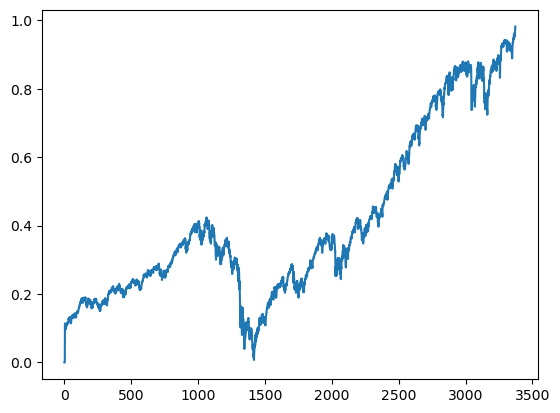

In [32]:
plt.plot(train_plot)

In [33]:
timeseries

array([[ 67.57396],
       [ 67.62167],
       [ 67.11063],
       ...,
       [455.2    ],
       [452.18   ],
       [452.18   ]], dtype=float32)

In [34]:
train_plot = [i*(maximum - minimum) + minimum for i in train_plot]

In [35]:
test_plot = [i*(maximum - minimum) + minimum for i in test_plot]

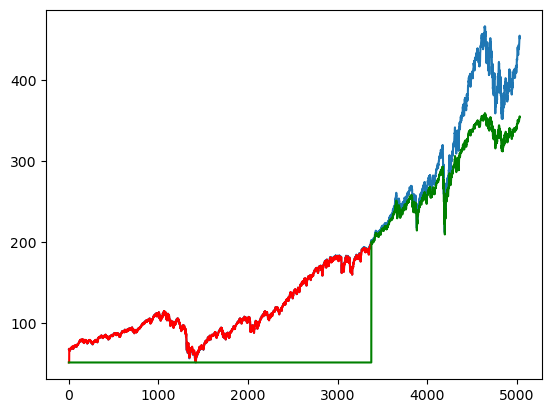

In [36]:
# # plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [26]:
train_plot

tensor([[ 68.1627],
        [ 67.7736],
        [ 67.5788],
        ...,
        [196.3851],
        [197.1405],
        [197.2290]])

In [27]:
test_plot

array([[      nan],
       [      nan],
       [      nan],
       ...,
       [199.15472],
       [199.242  ],
       [199.0111 ]], dtype=float32)

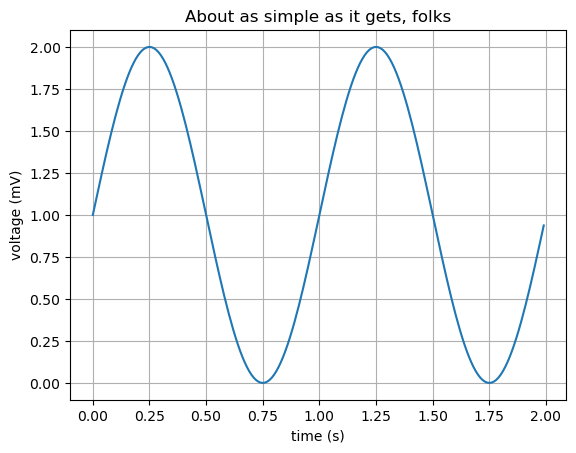

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

fig.savefig("test.png")
plt.show()